# Multi-Class Image Classification

We will learn how to create an algorithm to identify 10 categories of objects in the STL-10 dataset. We will use one of the state-of-the-art models pre-trained on the ImageNet dataset and fine-tune it on the STL-10 dataset. The ImageNet dataset, with over 14 million images and 1,000 categories, is one of the famous datasets that helped to push the boundaries in deep learning models. You can learn more about the ImageNet dataset at http://www.image-net.org/.

## **Loading and processing data**

We'll use the STL-10 dataset provided in the PyTorch torchvision package. There are 10 classes in the dataset:

* Airplane: 0
* Bird: 1
* Car: 2
* Cat: 3
* Deer: 4
* Dog: 5
* Horse:6
* Monkey: 7
* Ship: 8
* Truck: 9

The images are RGB color with a size of $96\times 96$. The dataset contains $5,000$ training images and $8,000$ test images. There are $500$ and $800$ images per class in the training and test datasets, respectively. There are more details about the dataset at https://cs.stanford.edu/~acoates/stl10/.

In the following section, we will load the data, display sample images, and create PyTorch dataloaders.

### **How to do it**

In [1]:
# 1 Let's load the training data
from torchvision import datasets
import torchvision.transforms as transforms
import os

path2data = "../data/STL/"
if not os.path.exists(path2data):
    os.mkdir(path2data)

data_transformer = transforms.Compose([transforms.ToTensor()])
train_ds=datasets.STL10(path2data, split='train', 
                        download=True,transform=data_transformer)
print(train_ds.data.shape)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ../data/STL/stl10_binary.tar.gz to ../data/STL/
(5000, 3, 96, 96)


In [3]:
# 2 Then countthe number of images per category in train_ds
import collections

y_train = [y for _, y in train_ds]
counter_train = collections.Counter(y_train)
print(counter_train)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})


In [4]:
# 3 Let's then load the test dataset and call it test0_ds
test0_ds = datasets.STL10(path2data, split='test', download=True, transform=data_transformer)
print(test0_ds.data.shape)

Files already downloaded and verified
(8000, 3, 96, 96)


In [10]:
# 4 Next, split the indices of test0_ds into 2 groups
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0)

indices = list(range(len(test0_ds)))
y_test0 = [y for _, y in test0_ds]
for test_index, val_index in sss.split(indices, y_test0):
    print("test:", test_index, "val:", val_index)
    print(len(val_index), len(test_index))

test: [2096 4321 2767 ... 3206 3910 2902] val: [6332 6852 1532 ... 5766 4469 1011]
1600 6400


In [12]:
# 5 Then create 2 dataset from test0_ds
from torch.utils.data import Subset

val_ds = Subset(test0_ds, val_index)
test_ds = Subset(test0_ds, test_index)

In [13]:
# 6 Next, count the number of images per class in val_ds and test_ds:
import collections
import numpy as np

y_test = [y for _, y in test_ds]
y_val = [y for _, y in val_ds]

counter_test = collections.Counter(y_test)
counter_val = collections.Counter(y_val)
print(counter_test)
print(counter_val)

Counter({6: 640, 0: 640, 4: 640, 5: 640, 9: 640, 2: 640, 3: 640, 1: 640, 7: 640, 8: 640})
Counter({2: 160, 8: 160, 3: 160, 6: 160, 4: 160, 1: 160, 5: 160, 9: 160, 0: 160, 7: 160})


In [15]:
# 7 Let's show a few sample images from train_ds. We will import the required packages:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(0)

# Now, we will define the helper function:
def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))

# Then pick random samples:

grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

image indices: [2732 2607 1653 3264]


torch.Size([3, 98, 389])


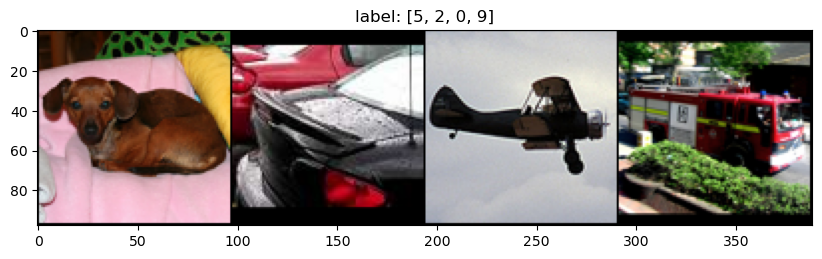

In [23]:
import torch

# We will create a grid from the sample images:
x_grid = [train_ds[i][0] for i in rnd_inds]
y_grid = [train_ds[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=4, padding=1)
print(x_grid.shape)

# The grid size is printed as follows: 
torch.Size([3, 100, 394])

# Then, we will call the helper function to display the grid:
# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

image indices: [ 684  559 1216  835]
torch.Size([3, 100, 394])


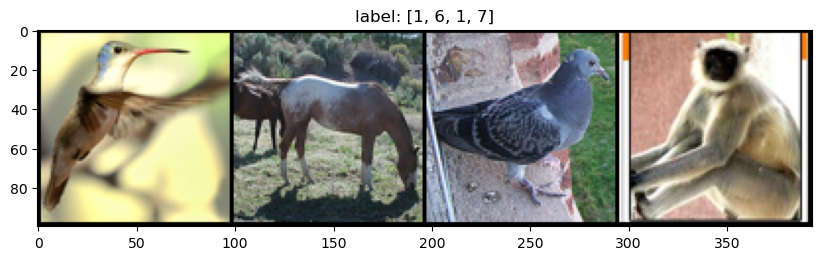

In [24]:
# 8 Let's show sample images from val_ds:
np.random.seed(0)

grid_size = 4
rnd_inds = np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)

x_grid = [val_ds[i][0] for i in rnd_inds]
y_grid = [val_ds[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [25]:
# 9 Let's calculate the mean and standard deviation of train_ds:
import numpy as np

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_ds]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_ds]

meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


In [26]:
# 10 Let's define the image transformations for train_ds and test0_ds:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])])

test0_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
    ])

# 11 Update the transform functions of train_ds and test0_ds:
train_ds.transform = train_transformer
test0_ds.transform = test0_transformer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [2732 2607 1653 3264]
torch.Size([3, 100, 394])


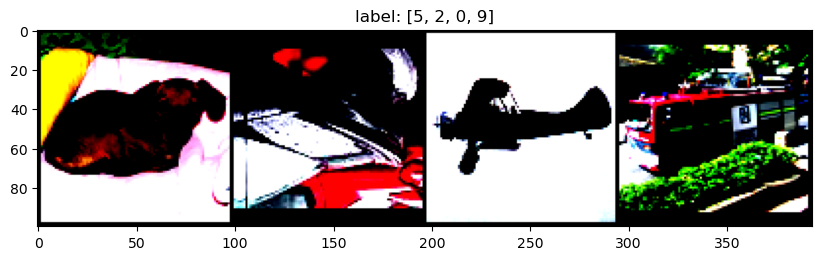

In [27]:
# 12 Next, we will display the transformed sample images from train_ds:
import torch
np.random.seed(0)
torch.manual_seed(0)

grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print("image indices:",rnd_inds)

x_grid = [train_ds[i][0] for i in rnd_inds]
y_grid = [train_ds[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [30]:
# 13 Le's create dataloaders from train_ds and val_ds:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

# 14 Then get a batch of data from train_dl:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 96, 96])
torch.Size([32])


In [31]:
# 15 Next, get a batch of data from val_dl:
# extract a batch from validation data
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 96, 96])
torch.Size([64])


### **How it works**

In step 1, we loaded the training dataset from `torchvision.datasets`. As seen, there are $5,000$ images of size $3 \times 96 \times 96$ in the training dataset. The initial `transform` function converts PIL images to tensors and normalizes pixel values in the range $[0, 1]$. Make sure that `Download = True` the first time you run the code. It will automatically download the dataset and store it in the data folder. After downloading once, you can set `Download=False`.

In step 2, we counted the number of images per class. As seen, there is an equal number of images in each class (a balanced dataset).

In step 3, we loaded the original test dataset and called it `test0_ds`. As seen, there are $8,000$ images in `test0_ds`. Since there is no official validation dataset, we split `test0_ds` indices into two groups, `val_index`, and `test_index`. In step 4 we used `StratifiedShuffleSplit` from `sklearn.model_selection`. This function **returns stratified randomized indices**.

In step 5, we used val_index and test_index to create two datasets: `val_ds` and `test_ds`. There are $1,600$ images in `val_ds` and $6,400$ remaining images in `test_ds`. We will use `val_ds` for the evaluation of the model during training.

Since we used the stratified randomized indices, we can see in step 6 that both `val_ds` and test_ds are balanced. In step 7 and step 8, we displayed sample images from `train_ds` and `val_ds`. We fixed the random seed using `np.random.seed(0)` so that the random indices are reproduced in different runs. If you want to see different random images in each run, comment out the line. In step 9, we calculated the mean and standard deviation of pixel values in `train_ds`. We will use these values for the normalization of data.

In step 10, we defined image transformations. For `train_ds`, we added `RandomHorizontalFlip` and `RandomVerticalFlip` to augment the training dataset. In addition, we applied zero-mean unit-variance normalization using `transforms.Normalize`. The arguments to this function are the mean and standard deviation per channel calculated in step 9. For `test0_ds`, we only added the normalization function since we do not require data augmentation for the validation and test datasets.

In step 11, we updated the `transform` functions of `train_ds` and `test0_ds`. Note that when we update the `test0_ds.transform` function, both `val_ds`, and `test_ds` will be updated since they are subsets of test0_ds. In step 12, we displayed sample images from `train_ds` with updated transformation. Note that, due to normalization, the pixel values of transformed images are clipped when displayed. As seen, three images are flipped horizontally or vertically.

In step 13, we created the PyTorch dataloaders `train_dl` and `val_dl` to be able to automatically fetch data batches from each dataset. In step 14 and step 15, we extracted a batch of data using the dataloaders. As seen, the extracted data size depends on the batch size.

### **There's more**

There are other built-in datasets in the `torchvision` package that can be similarly loaded for multi-class image classification. For example, you can load `FashionMNIST`, consisting of a training set of $60,000$ examples and a test set of 10,000 examples. Each example is a $28 \times 28$ grayscale image, associated with a label from $10$ classes.

Try the following code to load the `FashionMNIST` dataset:

```py
from torchvision import datasets
fashion_train=datasets.FashionMNIST(path2data, train=True, download=True)
```
Do you want to play with more datasets? See the next section to explore more.

## **Building the model**

We will build a model for our multi-class classification task. Instead of building a custom model, we'll use the `torchvision` models. The `torchvision` package provides the implementation of multiple state-of-the-art deep learning models for image classification. These include **AlexNet**, **VGG**, **ResNet**, **SqueezeNet**, **DenseNet**, **Inception**, **GoogleNet**, and **ShuffleNet**. These models were trained on the ImageNet dataset with over $14$ million images from $1,000$ classes. We can either use the architectures with randomly initialized weights or the pre-trained weights. In this recipe, we will try both cases and see the difference.

### **How to do it**

We will load a pre-trained model and visualize the convolutional layers in the first layer:

In [33]:
# 1 Let's import the resnet18 model with random weights from torchvision.models
from torchvision import models
import torch

model_resnet18 = models.resnet18(pretrained=False)

# 2 Let's print the model:
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
# 3 Let's change the output layer to 10 classes:
from torch import nn

num_classes = 10
num_ftrs = model_resnet18.fc.in_features 
model_resnet18.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda:0")
model_resnet18.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
# 4 Let's get the model summary:
from torchsummary import summary
summary(model_resnet18,input_size=(3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

torch.Size([64, 3, 7, 7])
0.0 1.0536777973175049
torch.Size([3, 65, 65])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


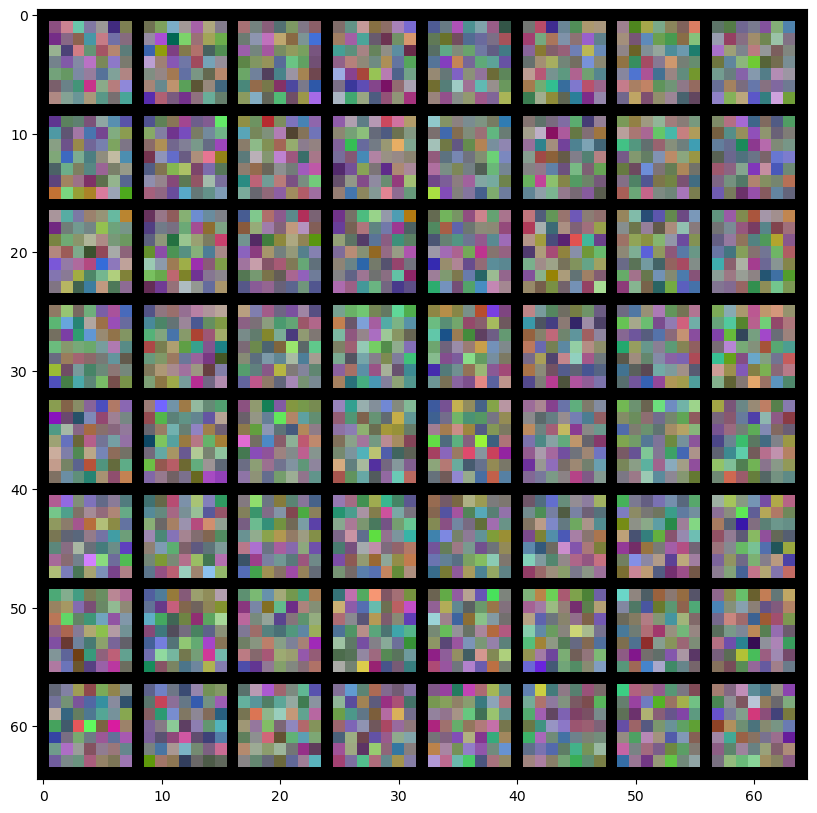

In [36]:
# 5 Let's visualize the filters of the first CNN layer:
# Let's get the weights of the first layer:
for w in model_resnet18.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# Then, normalize the weights:
min_w = torch.min(w)
w1 = (-1 / (2 * min_w)) * w + 0.5 
print(torch.min(w1).item(),torch.max(w1).item())
# Next, make a grid and display it:
grid_size=len(w1)
x_grid=[w1[i] for i in range(grid_size)]
x_grid=utils.make_grid(x_grid, nrow=8, padding=1)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid)

In [37]:
# 6 Let's load resnet18 with the pre-trained weights:
from torchvision import models
import torch

resnet18_pretrained = models.resnet18(pretrained=True)

num_classes=10
num_ftrs = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda:0")
resnet18_pretrained.to(device) 

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ibrao/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 7, 7])
0.0 1.102618932723999
torch.Size([3, 65, 65])


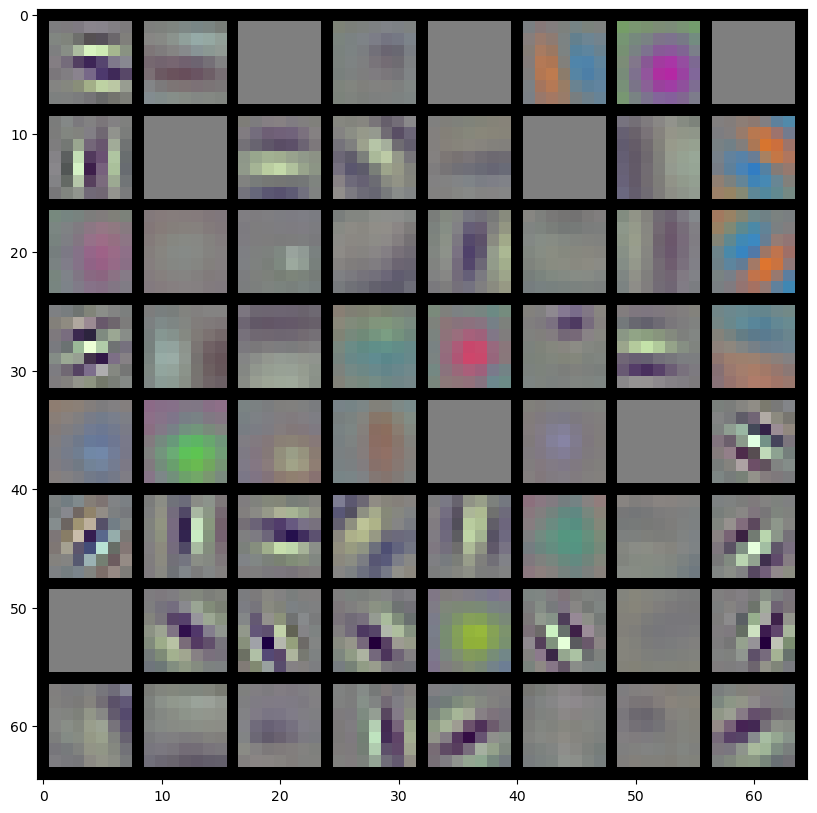

In [39]:
# 7 Let's visualize the filters of the first CNN layer using the snippet from step 5:
for w in resnet18_pretrained.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# Then, normalize the weights:
min_w = torch.min(w)
w1 = (-1 / (2 * min_w)) * w + 0.5 
print(torch.min(w1).item(),torch.max(w1).item())
# Next, make a grid and display it:
grid_size=len(w1)
x_grid=[w1[i] for i in range(grid_size)]
x_grid=utils.make_grid(x_grid, nrow=8, padding=1)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid)

In step 1, we loaded the `resnet18` model. This will automatically download the model and store it locally for future use. An important argument when loading a model is `pretrained`. If set to `False`, the model weights will be initialized randomly.

In step 2, we printed the model. As seen, the last layer is a linear layer with $1,000$ outputs. The resnet18 model was developed for the `ImageNet` dataset with $1,000$ classes. Therefore, we change the last layer to have `num_classes = 10` outputs for our classification task in step 3. This change can be seen in step 4 when we get the model summary. Even though the original image sizes are $96 \times 96$, we need to resize them to $224 \times 224$, the same size that the resnet18 model was trained at.

In step 5, we visualized the convolutional filters of the first layer. Since filters are randomly initialized, they show random patterns without any structure. Later, we will see the same filters for the pre-trained model.

In step 6, we loaded the `resnet18` model with `pretrained = True`. This will load the model with the pre-trained weights on the `ImageNet` dataset. In step 7, we displayed the filters of the first layer. As seen, the filters represent some patterns and structures such as edges.

### **There's more**

The `torchvision.models` package provides the definitions of more models. Try to load other pre-trained models and change the last layer to match our dataset with 10 classes. For instance, you can load `vgg19` using the following code:

```python
num_classes=10
vgg19 = models.vgg19(pretrained=True)
vgg19.classifier[6] = nn.Linear(4096, num_classes) # change the last layer
```

## **Defining the loss function**

The goal of defining a loss function is **to optimize the model toward a pre-defined metric**. The **standard loss function for classification tasks is cross-entropy loss or log loss**. However, in defining the loss function, we **need to consider the number of model outputs and their activation functions**. For **multi-class classification tasks, the number of outputs is set to the number of classes**. The **output activation function then determines the loss function**.

The following table shows the corresponding loss function for different activation functions:

| Output activation | Number of outputs | Loss function         |
| ----------------- | ----------------- | --------------------- |
| `None`            | `num_classes`     | `nn.CrossEntropyLoss` |
| `log_Softmax`     | `num_classes`     | `nn.NLLLoss`          |

The resnet18 model defined in the Building the model section has linear outputs with no activation function. Therefore, we choose `nn.CrossEntropyLoss` as the loss function. This loss function combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one class.

### **How to do it**

We will define the loss function and test it with random values:

In [40]:
# 1 Define the loss function as the following:
loss_func = nn.CrossEntropyLoss(reduction="sum")

# 2 Let's see the loss in an example:
torch.manual_seed(0)

n, c = 4, 5
y = torch.randn(n, c, requires_grad=True)
print(y.shape)

loss_func = nn.CrossEntropyLoss(reduction="sum")
target = torch.randint(c, size=(n,))
print(target.shape)

loss = loss_func(y, target)
print(loss.item())

torch.Size([4, 5])
torch.Size([4])
7.312585830688477


In [41]:
# 3 Let's compute the gradients of loss with respect to y:
loss.backward()
print(y.data)

tensor([[-1.1258, -1.1524, -0.2506, -0.4339,  0.5988],
        [-1.5551, -0.3414,  1.8530,  0.4681, -0.1577],
        [ 1.4437,  0.2660,  1.3894,  1.5863,  0.9463],
        [-0.8437,  0.9318,  1.2590,  2.0050,  0.0537]])


### **How it works**

In step 1, we defined the loss function. The `resnet18` model uses linear outputs. Thus, we use `nn.CrossEntropyLoss` as the loss function. **An important argument in defining the loss function to pay attention to its** `reduction`, which **specifies the reduction to apply to the output**. There are three options to choose from: `none`, `sum`, and `mean`. We choose `reduction="sum"` so **the output loss will be summed**. Since we will process the data in batches, this will **return the sum of loss values per batch of data**.

In step 2, we calculated the loss using an example with `n=4` samples and `c=5` classes.

In step 3, we computed the gradients for the example in step 2. Later, we will use the `backward` method to **compute the gradients of loss with respect to the model parameters**.

## **Defining the optimizer**

The `torch.optim` package provides the implementation of common optimizers. The optimizer will hold the current state and will update the parameters based on the computed gradients. For classification tasks, **Stochastic Gradient Descent (SGD)** and Adam optimizer are very common to use. The choice of an optimizer for your model is considered a hyperparameter. You usually need to try multiple optimizers to find the best performing one. Adam optimizer outperforms the SGD in terms of speed and accuracy most often, so we will choose Adam optimizer here. However, you can try a different optimizer and see for yourself.

Other nice tools in the `torch.optim` package are learning schedules. Learning schedules are useful tools to automatically adjust the learning rate during training to improve model performance. 

In this recipe, we will learn how to define an optimizer, get the current learning rate, and define a learning scheduler.

### **How to do it**

In [42]:
# 1 Define an Adam optimizer object with a learning rate of 1e-4:
from torch import optim
opt = optim.Adam(model_resnet18.parameters(), lr=1e-4)

# 2 We can read the current value of the learning rate using the following function:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr = get_lr(opt)
print('current lr={}'.format(current_lr))


current lr=0.0001


In [44]:
# 3 Define a learning scheduler using the CosineAnnealingLR method:
from torch.optim.lr_scheduler import CosineAnnealingLR

lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-5)

# 4 Let's see how the learning rate schedule works using the following example:
for i in range(10):
    opt.step()
    lr_scheduler.step()
    print("epoch %s, lr: %.1e" %(i, get_lr(opt)))

epoch 0, lr: 1.0e-05
epoch 1, lr: 1.0e-05
epoch 2, lr: 5.5e-05
epoch 3, lr: 1.0e-04
epoch 4, lr: 5.5e-05
epoch 5, lr: 1.0e-05
epoch 6, lr: 5.5e-05
epoch 7, lr: 1.0e-04
epoch 8, lr: 5.5e-05
epoch 9, lr: 1.0e-05


### **How it works**

In step 1, we defined Adam optimizer. As mentioned before, **Adam optimizer outperforms other optimizers for classification tasks most of the time**. However, this should not be considered a rule. **Consider choosing the optimizer as a hyperparameter and try a few different optimizers to see which one performs better**. The important parameters of the `optimizer` class are the model parameters and the learning rate. `model_resnet18.parameters()` **returns an iterator over module parameters that are passed to the optimizer**. **The learning rate will determine the number of updates**. We set one learning rate for all the layers.

In step 2, we developed a helper function that returns the current value of the learning rate.

In step 3, we used the `CosineAnnealingLR` method from the `torch.optim.lr_scheduler` package. **This scheduler adjusts the learning rate based on a cosine annealing schedule**. <font color=yellow>The learning rate starts from the set value in the optimizer `lr=1e-4`. Then, it gradually decreases toward `eta_min=1e-5` and returns back to the original set value in `2*T_max=4` iterations</font>.

The following screenshot depicts a plot of the learning rate values over 10 epochs:

![](plot.png)

## **Training and transfer learning**

By now, we have created the datasets and defined the model, loss function, and optimizer. In this recipe, we will implement the training and validation scripts. We'll first train the model with randomly initialized weights. Then, we'll train the model with the pre-trained weights. **This technique is also called transfer learning. In transfer learning, we try to use the knowledge (weights) learned from one problem in other similar problems**. The training and validation scripts could be long and repetitive. For better code readability and to avoid code repetition, we'll first build a few helper functions.

### **How to do it**

In [46]:
# 1 First, develop a helper function to count the number of correct predictions per data batch:
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

# 2 We then develop a helper function to compute the loss value per batch of data:
def loss_batch(loss_func, output, target, opt=None):  
    loss = loss_func(output, target)   
    metric_b = metrics_batch(output,target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

# 3 Next, we develop a helper function to compute the loss value and the performance
# metric for the entire dataset or an epoch.

# We start the helper function by initializing variables:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss+=loss_b
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break

    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric

# 4 Let's develop the train_val function in the following code block.
# The helper function starts by extracting the parameters:
import copy
def train_val(model, params):
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]

    loss_history = {
        "train": [],
        "val": [],
    }
    
    metric_history = {
        "train": [],
        "val": [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        model.train()
        train_loss, train_metric=  loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")

        lr_scheduler.step()

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10)
    
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [47]:
# 5 Let's train the model by calling the train_val function.

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model_resnet18.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5, eta_min=1e-6)

# We will set the training parameters and call the train_val function:
os.makedirs("../models", exist_ok=True)

params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": "../models/resnet18.pt",
}

model_resnet18,loss_hist,metric_hist = train_val(model_resnet18,params_train)

Epoch 0/99, current lr=0.0001
Copied best model weights!
train loss: 1.780072, dev loss: 1.540176, accuracy: 39.50
----------
Epoch 1/99, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 1.455455, dev loss: 1.442003, accuracy: 43.62
----------
Epoch 2/99, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 1.274854, dev loss: 1.418625, accuracy: 47.19
----------
Epoch 3/99, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 1.071958, dev loss: 1.311411, accuracy: 52.19
----------
Epoch 4/99, current lr=1.0453658778440105e-05
Copied best model weights!
train loss: 0.926842, dev loss: 1.266252, accuracy: 54.56
----------
Epoch 5/99, current lr=1e-06
Copied best model weights!
train loss: 0.872561, dev loss: 1.262592, accuracy: 55.25
----------
Epoch 6/99, current lr=1.0453658778440102e-05
train loss: 0.881874, dev loss: 1.281225, accuracy: 53.37
----------
Epoch 7/99, current lr=3.520365877844009e-05
train loss: 0.880017, dev l

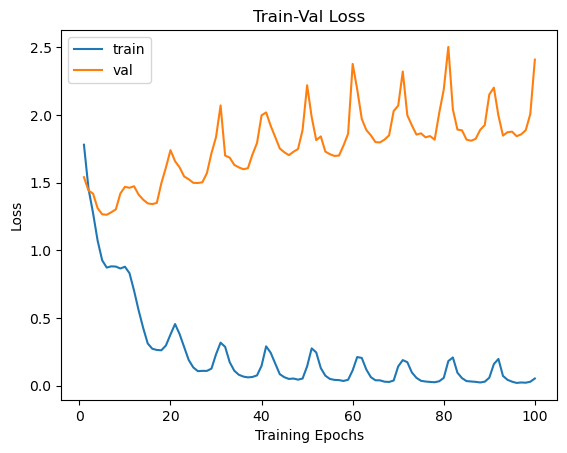

In [48]:
# 6 Next, we will plot the progress of the loss values throughout the training:
num_epochs = params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs+1), loss_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), loss_hist["val"], label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

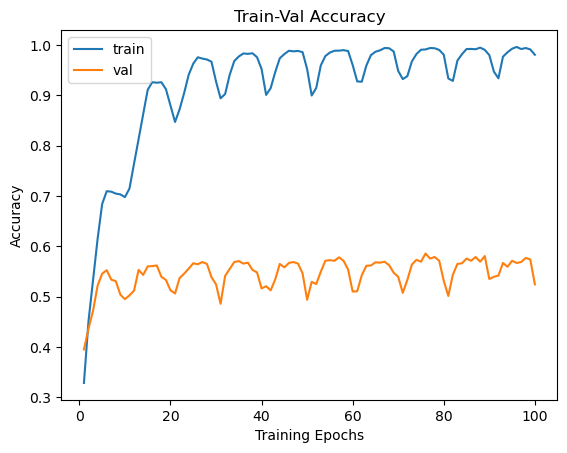

In [49]:
# Then, we will plot the progress of the accuracy values throughout the training:
plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs+1), metric_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), metric_hist["val"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [50]:
# 7 Now, let's train the model with the pre-trained weights:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(resnet18_pretrained.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5, eta_min=1e-6)

params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": "../models/resnet18_pretrained.pt",
}

resnet18_pretrained, loss_hist,metric_hist = train_val(resnet18_pretrained, params_train)

Epoch 0/99, current lr=0.0001
Copied best model weights!
train loss: 0.921249, dev loss: 0.446965, accuracy: 83.56
----------
Epoch 1/99, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.433851, dev loss: 0.392434, accuracy: 86.50
----------
Epoch 2/99, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.299896, dev loss: 0.360679, accuracy: 86.88
----------
Epoch 3/99, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 0.207092, dev loss: 0.331075, accuracy: 88.31
----------
Epoch 4/99, current lr=1.0453658778440105e-05
Copied best model weights!
train loss: 0.164224, dev loss: 0.324304, accuracy: 88.62
----------
Epoch 5/99, current lr=1e-06
train loss: 0.153561, dev loss: 0.324919, accuracy: 88.38
----------
Epoch 6/99, current lr=1.0453658778440102e-05
train loss: 0.145899, dev loss: 0.332160, accuracy: 89.00
----------
Epoch 7/99, current lr=3.520365877844009e-05
train loss: 0.133199, dev loss: 0.335579, accuracy: 88

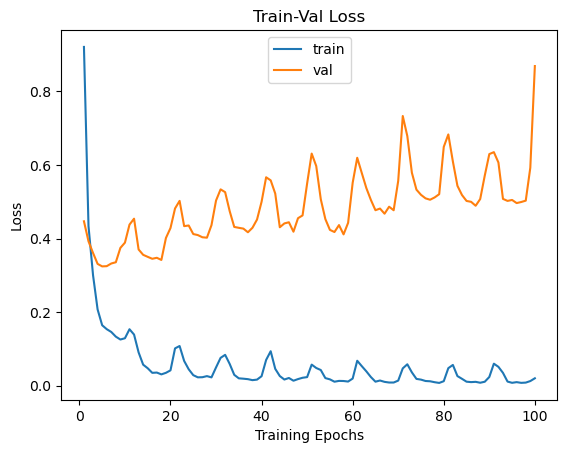

In [51]:
# 8 Let's plot the training-validation progress:
num_epochs = params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs+1), loss_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), loss_hist["val"], label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

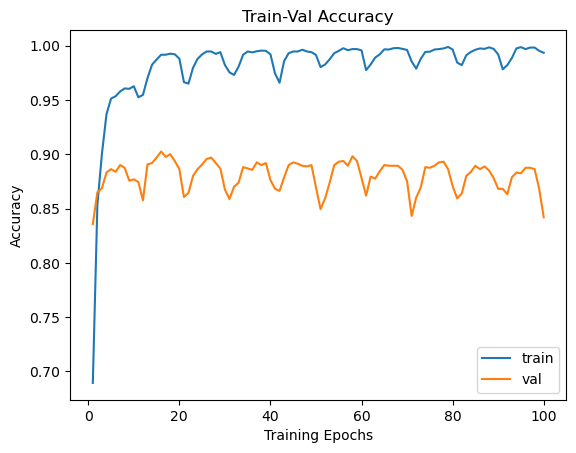

In [52]:
plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs+1), metric_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), metric_hist["val"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

### **How it works**

In step 1, we developed a helper function to count the number of correct predictions per batch to be later used for calculating the model accuracy.

In step 2, we developed the `loss_batch` helper function. This function receives the loss function and optimizer objects, the model output, and the ground truth label. We only performed the backpropagation step during training. 

In step 3, the `loss_epoch` helper function receives the model, loss function, dataloader, and optimizer objects. We used the dataloader to fetch batches of data from the dataset. We then moved the batch to the CUDA device and got the model output. We also declared two variables to keep the loss and the number of correct predictions after a batch is executed. You saw how the choice of `reduction="sum"` in the definition of the loss function is deployed to accumulate the loss over the entire dataset. The `sanity_check` flag breaks the loop for the quick execution of the function in the case of debugging.

In step 4, we passed the parameters as a Python dictionary. This will improve the code readability. We defined two dictionaries to record the loss and metric values during training for visualization purposes.

An important step is to track the model's performance during training to avoid overfitting. To this end, we evaluated the model on the validation dataset after each training epoch. We then compared the validation loss with the best validation loss: `val_loss < best_loss`. If the validation loss has improved, we will store and make a copy of the weights as the best model weights.

The learning rate scheduler reduces the learning rate using a cosine annealing schedule:

```Python
lr_scheduler.step() # learning rate schedule
```


We recommended a sanity check before starting the actual training. We created a flag called `sanity_check` for this purpose. If set to `True`, the training loop breaks after one batch in an epoch. Therefore, we get to see the whole loop in a short amount of time.

In step 5, we trained the model. We saw that the learning rate schedule will reduce the learning rate in each epoch toward `eta_min=1e-6`. As seen, after $10$ epochs, the learning is reset with the initial value.

We stored the best model weights (state_dict) during training by tracking the model's performance on the validation dataset. The weights are located in the `"../models/weights.pt"` local path. This is useful if the program is stopped for any reason—at least you have a copy of the best weights.

In step 6, we saw the plot of loss and accuracy values for both the training and validation datasets. You also saw that training the resnet18 model from scratch does not lead to an impressive performance (validation accuracy is around $0.65$). That is because the training data is not sufficient to train such a large model. That is why using pre-trained models or transfer learning can be beneficial.

In step 7, we used the pre-trained weights for transfer learning. This will help the model's performance to significantly jump to above $90\%$ even for initial epochs. This is the power of transfer learning. The plots of loss and accuracy values are depicted in step 8.

## **Deploying the model**

Let's assume that you want to deploy the model for inference in a new script separate from the training scripts. In this case, the model and weights do not exist in memory. So, we need to construct an object of the model class and then load the stored weights into the model.

### **How to do it**

We will load the model parameters, verify the model's performance, and deploy the model on the test dataset:

In [53]:
# 1 Load the resnet18 model:
from torch import nn
from torchvision import models

model_resnet18 = models.resnet18(pretrained=False)
num_ftrs = model_resnet18.fc.in_features
num_classes = 10
model_resnet18.fc = nn.Linear(num_ftrs, num_classes)

# 2 Let's load state_dict from the stored file into the model:
import torch

path2weights = "../models/resnet18_pretrained.pt"
model_resnet18.load_state_dict(torch.load(path2weights))

# 3 Then, we will set the model in evaluation mode:
model_resnet18.eval()

# 4 Next, we will move the model onto the CUDA device if available:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model_resnet18 = model_resnet18.to(device)

# 5 Next, we will develop a helper function to deploy the model on a dataset.
# The helper function starts with initialization:
import time

def deploy_model(model, dataset, device, num_classes=10, sanity_check=False):
    len_data = len(dataset)
    y_out = torch.zeros(len_data, num_classes)
    y_gt = np.zeros((len_data), dtype="uint8")
    model = model.to(device)
    elapsed_times = []
    # The helper function continues with a loop over the dataset:
    with torch.no_grad():
        for i in range(len_data):
            x, y = dataset[i]
            y_gt[i] = y
            start = time.time()    
            yy = model(x.unsqueeze(0).to(device))
            y_out[i] = torch.softmax(yy,dim=1)
            elapsed = time.time() - start
            elapsed_times.append(elapsed)

            if sanity_check is True:
                break

    inference_time = np.mean(elapsed_times) * 1000
    print("average inference time per image on %s: %.2f ms " %(device, inference_time))
    return y_out.numpy(), y_gt

In [54]:
# 6 Then, we will call the function to deploy the model on the validation dataset:
import numpy as np

y_out, y_gt = deploy_model(model_resnet18, val_ds, device=device, sanity_check=False)
print(y_out.shape, y_gt.shape)

average inference time per image on cuda: 22.15 ms 
(1600, 10) (1600,)


In [55]:
# 7 Let's calculate the accuracy of the model on the validation dataset using the predicted outputs:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(y_out, axis=1)
print(y_pred.shape, y_gt.shape)

acc = accuracy_score(y_pred, y_gt)
print("accuracy: %.2f" %acc)

(1600,) (1600,)
accuracy: 0.89


In [56]:
# 8 Let's deploy the model on test_ds:
y_out,y_gt = deploy_model(model_resnet18, test_ds, device=device)

y_pred = np.argmax(y_out, axis=1)
acc = accuracy_score(y_pred, y_gt)
print(acc)

average inference time per image on cuda: 21.56 ms 
0.88546875


In [57]:
# 9 Next, we will display a few sample images from test_ds.
# We will import the required packages:

from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(1)

# Then, we will define the helper function:
def imshow(inp, title=None):
    mean = [0.4467106, 0.43980986, 0.40664646]
    std = [0.22414584, 0.22148906, 0.22389975]
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated 

image indices: [2244 4121 3439 5591]
torch.Size([3, 100, 394])


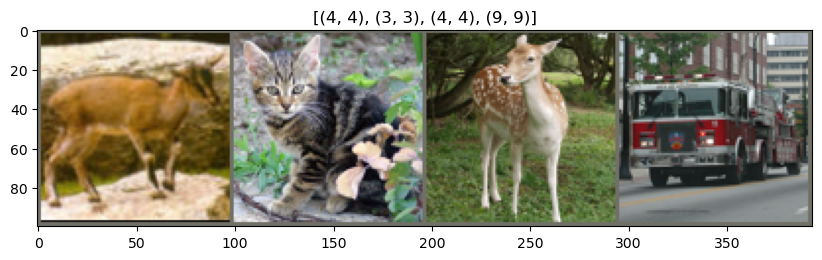

In [59]:
# Then, we will create a grid and display it:
grid_size = 4
rnd_inds = np.random.randint(0, len(test_ds), grid_size)
print("image indices:", rnd_inds)

x_grid_test = [test_ds[i][0] for i in rnd_inds]
y_grid_test = [(y_pred[i], y_gt[i]) for i in rnd_inds]

x_grid_test = utils.make_grid(x_grid_test, nrow=4, padding=2)
print(x_grid_test.shape)

plt.rcParams['figure.figsize'] = (10, 5)
imshow(x_grid_test, y_grid_test)

In [ ]:
# 10 Let's also measure the inference time on the cpu device:
# device_cpu = torch.device("cpu")
# y_out, y_gt = deploy_model(model_resnet18, val_ds, device=device_cpu, sanity_check=False)
# print(y_out.shape,y_gt.shape)

### **How it works**

In step 1, we loaded the built-in model from `torchvision.models`. In step 2, we loaded `state_dict`, which contains the model weights in the model. For deployment, it is necessary to set the model to evaluation mode. This is important since some layers (such as dropout and BatchNorm) perform differently in training and deployment modes. If the CUDA device is available, we should move the model onto the CUDA device. The model is ready to be deployed.

In step 5, the helper function returns the model outputs and ground truth labels as NumPy arrays for the dataset. Also, the inference time per image on the CUDA device is estimated to be $3.53$ ms. Later, we will see the inference time on the CPU device.

In step 6, we verified the stored model by deploying it on the validation dataset. Lots of things can go wrong during the development of deep learning models. We recommended verifying the stored model's performance by deploying the model on a known dataset, for instance, the validation dataset.

In step 7, we used the `scikit-learn` package to calculate the accuracy of our binary classification model. 

This shows an accuracy of $0.94$ on the validation dataset. This is a good verification of our model.

In step 8, we deployed the model on `test_ds`. We did not use `test_ds` for validation, so it can be considered a hidden dataset to the model. Luckily, we have the labels for `test_ds` too and we can evaluate the model's performance on `test_ds`. This shows an accuracy of $0.95$, which is close to the accuracy of `val_ds`.

In step 9, we displayed a few sample images and the predicted labels from `test_ds`.

In step 10, we wanted to see the deployment time on the CPU. This would be informative if we wanted to deploy the model on devices without a GPU. As seen, the deployment time is around $25$ ms per image. This is still a low number, which could be used for many real-time applications.